In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from galton import galton_rvs
from galton import galton_rvs_ratio

In [2]:
from galton import n_nails
from galton import n_rows

theta_0 = -0.8
theta_1 = -0.6

# Density estimation with histograms

In [3]:
samples_0, _, scores_0, _ = galton_rvs(theta_0, n_runs=20000, random_state=1234)
p_estimated_0, _ = np.histogram(
    samples_0, bins=n_nails, range=(0, n_nails), density=True
)

samples_1, _, scores_1, _ = galton_rvs(theta_1, n_runs=20000, random_state=1234)
p_estimated_1, _ = np.histogram(
    samples_1, bins=n_nails, range=(0, n_nails), density=True
)

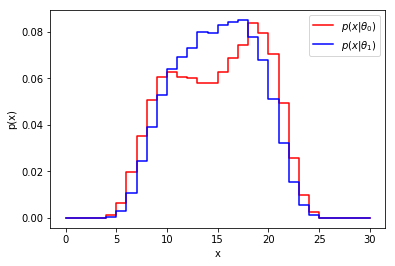

In [4]:
plt.step(
    range(len(p_estimated_0)), p_estimated_0, c="r", lw=1.5, label=r"$p(x|\theta_0)$"
)
plt.step(
    range(len(p_estimated_0)), p_estimated_1, c="b", lw=1.5, label=r"$p(x|\theta_1)$"
)

plt.xlabel("x")
plt.ylabel("p(x)")
plt.legend()
plt.show()

# NDE + SCANDAL

In [5]:
from galton import check_random_state
from keras.utils import to_categorical


def draw_nde(n_samples, n_thetas=10, random_state=0):
    n_traces_per_theta = n_samples // n_thetas

    all_x = []
    all_t_xz = []
    all_thetas = []

    for k, theta in enumerate(np.linspace(-1.0, -0.4, n_thetas)):
        x, log_p_xz, t_xz, _ = galton_rvs(
            theta, n_runs=n_traces_per_theta, random_state=random_state + k
        )
        all_x.append(x)
        all_t_xz.append(t_xz)
        all_thetas.append(theta * np.ones(n_traces_per_theta))

    all_x = np.array(all_x).reshape(-1, 1)
    all_x = to_categorical(all_x, num_classes=n_nails)
    all_t_xz = np.array(all_t_xz).reshape(-1, 1)
    all_thetas = np.array(all_thetas).reshape(-1, 1)

    rng = check_random_state(random_state)
    choices = rng.choice(len(all_x), len(all_x), replace=False)

    return all_x[choices], all_t_xz[choices], all_thetas[choices]

/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [6]:
x, t_xz, theta = draw_nde(10000)

In [7]:
n_features = 1 
hidden_size = 20
n_outputs = n_nails

In [8]:
from keras.optimizers import Adam
from keras.layers import Input, Dense, Lambda, dot
from keras.models import Model
from keras.utils import to_categorical
import keras.backend as K


def make_nde(lr=0.001):
    theta = Input(shape=(1,))
    h = Dense(hidden_size, activation="tanh")(theta)
    phat_theta = Dense(n_outputs, activation="softmax")(h)

    model = Model(inputs=[theta], outputs=[phat_theta])
    opt = Adam(lr=lr)
    model.compile(loss=["categorical_crossentropy"], optimizer=opt)

    return model


def make_scandal(lr=0.001):
    theta = Input(shape=(1,))
    h = Dense(hidden_size, activation="tanh")(theta)
    phat_theta = Dense(n_outputs, activation="softmax")(h)

    x = Input(shape=(n_outputs,))
    phat_x_theta = dot([x, phat_theta], axes=1)
    t_x = Lambda(
        lambda exp: K.gradients(K.log(exp[0]), [exp[1]])[0], output_shape=(n_features,)
    )([phat_x_theta, theta])

    model = Model(inputs=[theta, x], outputs=[phat_theta, t_x])
    opt = Adam(lr=lr)
    model.compile(loss=["categorical_crossentropy", "mse"], optimizer=opt)

    return model

In [9]:
nde = make_nde()
nde.fit(theta, x,
        batch_size=32, epochs=50, verbose=0)

In [10]:
scandal = make_scandal()
scandal.fit(
    [theta, x],
    [x, t_xz],
    batch_size=32,
    epochs=50,
    verbose=0
)

Epoch 1/50
10000/10000 [==============================] - 1s 83us/step - loss: 4.9660 - dense_4_loss: 3.2598 - lambda_1_loss: 1.7062
Epoch 2/50
10000/10000 [==============================] - 0s 44us/step - loss: 4.0931 - dense_4_loss: 2.9489 - lambda_1_loss: 1.1442
Epoch 3/50
10000/10000 [==============================] - 0s 43us/step - loss: 3.9007 - dense_4_loss: 2.8302 - lambda_1_loss: 1.0705
Epoch 4/50
10000/10000 [==============================] - 0s 44us/step - loss: 3.8399 - dense_4_loss: 2.8016 - lambda_1_loss: 1.0383
Epoch 5/50
10000/10000 [==============================] - 0s 43us/step - loss: 3.8098 - dense_4_loss: 2.7921 - lambda_1_loss: 1.0177
Epoch 6/50
10000/10000 [==============================] - 0s 44us/step - loss: 3.7893 - dense_4_loss: 2.7881 - lambda_1_loss: 1.0012
Epoch 7/50
10000/10000 [==============================] - 0s 44us/step - loss: 3.7748 - dense_4_loss: 2.7858 - lambda_1_loss: 0.9890
Epoch 8/50
10000/10000 [==============================] - 0s 44us/ste

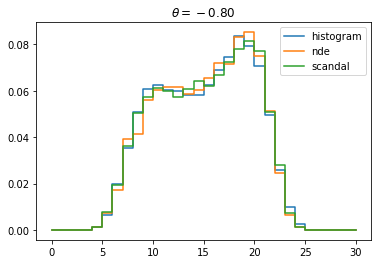

In [11]:
plt.step(range(n_nails), p_estimated_0, label="histogram")
plt.step(range(n_nails), nde.predict(np.array([theta_0])).ravel(), label="nde")
plt.step(
    range(n_nails),
    scandal.predict([np.array([[theta_0]]), np.zeros((1, n_nails))])[0][0],
    label="scandal",
)
plt.legend()
plt.title(r"$\theta=%.2f$" % theta_0)
plt.show()

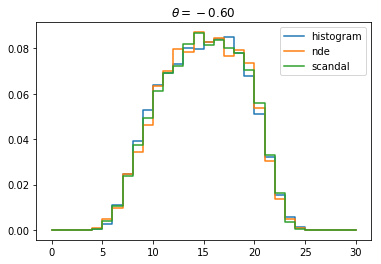

In [12]:
plt.step(range(n_nails), p_estimated_1, label="histogram")
plt.step(range(n_nails), nde.predict(np.array([theta_1])).ravel(), label="nde")
plt.step(
    range(n_nails),
    scandal.predict([np.array([[theta_1]]), np.zeros((1, n_nails))])[0][0],
    label="scandal",
)
plt.legend()
plt.title(r"$\theta=%.2f$" % theta_1)
plt.show()

# CARL

In [20]:
from keras.layers import concatenate


def make_carl(lr=0.001):
    theta0 = Input(shape=(1,))
    
    h = Dense(hidden_size, activation="tanh")(theta0)
    log_rhat_thetas = Dense(n_outputs, activation="linear")(h)
    rhat_thetas = Lambda(lambda exp: K.exp(exp))(log_rhat_thetas)

    x = Input(shape=(n_outputs,))
    rhat_x_thetas = dot([x, rhat_thetas], axes=1)
    
    shat = Lambda(lambda r: 1. / (1. + r))(rhat_x_thetas)

    model = Model(inputs=[theta0, x], outputs=[shat])
    opt = Adam(lr=lr)
    model.compile(loss=["binary_crossentropy"], optimizer=opt)
    
    return model


def make_carl_alt(lr=0.001):
    theta0 = Input(shape=(1,))
    x = Input(shape=(1,))
    
    h = Dense(hidden_size, activation="tanh")(
        concatenate([theta0, x])
    )
    h = Dense(hidden_size, activation="tanh")(h)
    log_rhat = Dense(1, activation="linear")(h)
    rhat = Lambda(lambda exp: K.exp(exp))(log_rhat)
    shat = Lambda(lambda r: 1. / (1. + r))(rhat)

    model = Model(inputs=[theta0, x], outputs=[shat])
    opt = Adam(lr=lr)
    model.compile(loss=["binary_crossentropy"], optimizer=opt)
    
    return model

In [21]:
def log_r_from_s(s, epsilon=1.e-6):
    return np.log((1. - s + epsilon) / (s + epsilon))

In [22]:
def draw_ratio(n_samples, n_thetas=10, random_state=0,
               draw_from_theta0=True, draw_from_theta1=True, categorical_x=True):
    n_traces_per_theta = n_samples // n_thetas // (int(draw_from_theta0) + int(draw_from_theta1))

    all_x = []
    all_theta = []
    all_y = []
    all_r_xz = []
    all_t_xz_0 = []
    
    for k, theta in enumerate(np.linspace(-1.0, -0.4, n_thetas)):
        # Draw according to theta0
        if draw_from_theta0:
            x, log_p_xz_0, log_p_xz_1, t_xz_0, _, _ = galton_rvs_ratio(
                theta_0, theta_1, n_runs=n_traces_per_theta, random_state=random_state
            )
            all_x.append(x)
            all_y += [0] * n_traces_per_theta
            all_r_xz.append(log_p_xz_0 - log_p_xz_1)
            all_t_xz_0.append(t_xz_0)
            all_theta += [theta] * n_traces_per_theta
        
        # Draw according to theta1
        if draw_from_theta1:
            x, log_p_xz_1, log_p_xz_0, _, t_xz_0, _ = galton_rvs_ratio(
                theta_1, theta_0, n_runs=n_traces_per_theta, random_state=random_state
            )
            all_x.append(x)
            all_y += [1] * n_traces_per_theta
            all_r_xz.append(log_p_xz_0 - log_p_xz_1)
            all_t_xz_0.append(t_xz_0)
            all_theta += [theta] * n_traces_per_theta
        
    all_x = np.array(all_x).reshape(-1, 1)
    if categorical_x:
        all_x = to_categorical(all_x, num_classes=n_nails)
    all_theta = np.array(all_theta).reshape(-1, 1)
    all_y = np.array(all_y)
    all_r_xz = np.array(all_r_xz).reshape(-1, 1)
    all_r_xz = np.exp(all_r_xz)
    all_t_xz_0 = np.array(all_t_xz_0).reshape(-1, 1)

    return all_x, all_theta, all_y, all_r_xz, all_t_xz_0

In [23]:
# Calibration
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.isotonic import IsotonicRegression

def make_calibrated_carl_alt(theta, x, y, n_splits=3, test_size=0.5):
    cv = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size)

    classifiers = []
    calibrators = []

    for train, calibrate in cv.split(x, y):
        # Train classifier
        clf = make_carl_alt()
        clf.fit([theta[train], x[train]],
                y[train],
                batch_size=32, epochs=50, verbose=0)
        classifiers.append(clf)

        # Isotonic calibration
        T = clf.predict([theta[calibrate], x[calibrate]])
        cal = IsotonicRegression(y_min=None, y_max=None,
                                 increasing=True, out_of_bounds='clip')
        cal.fit(T.flatten(), y[calibrate].flatten())
        calibrate = lambda s : cal.transform(s.flatten())
        calibrators.append(calibrate)

    def calibrated_carl_prediction(theta_, x_):
        x_ = x_.astype(np.float)
        s = np.zeros_like(x_)
        for clf, calibrate in zip(classifiers, calibrators):
            s += calibrate(clf.predict([theta_, x_]))
        s /= len(classifiers)
        return s
    
    return calibrated_carl_prediction

In [24]:
x, theta, y, _, _ = draw_ratio(5000)
theta_x = np.hstack([all_theta, all_x])

x_alt, theta_alt, y_alt, _, _ = draw_ratio(5000, categorical_x=False)
theta_x_alt = np.hstack([all_theta_alt, all_x_alt])

In [25]:
carl = make_carl()
carl.fit([theta, x],
         y, 
         batch_size=32, epochs=50, verbose=0)

In [26]:
carl_alt = make_carl_alt()
carl_alt.fit([theta_alt, x_alt],
             y_alt, 
             batch_size=32, epochs=50, verbose=0)

In [27]:
carl_calibrated = make_calibrated_carl_alt(theta_alt, x_alt, y_alt)

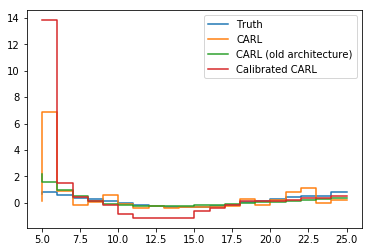

In [28]:
log_r_true = np.log(p_estimated_0[5:-5]) - np.log(p_estimated_1[5:-5])

x_test = to_categorical(np.array(range(n_nails)), num_classes=n_nails)
x_test_alt = np.array(range(n_nails))
theta0_test = theta_0 * np.ones((n_nails, 1))

log_r_carl = log_r_from_s(
    carl.predict([theta0_test, x_test])[5:-5]
)
log_r_carl_alt = log_r_from_s(
    carl_alt.predict([theta0_test, x_test_alt])[5:-5]
)
log_r_carl_calibrated = log_r_from_s(
    carl_calibrated(theta0_test, x_test_alt)[5:-5]
)

plt.step(range(5, n_nails - 5), log_r_true, label="Truth")
plt.step(range(5, n_nails - 5), log_r_carl, label="CARL")
plt.step(range(5, n_nails - 5), log_r_carl_alt, label="CARL (old architecture)")
plt.step(range(5, n_nails - 5), log_r_carl_calibrated, label="Calibrated CARL")
plt.legend()
plt.show()

# ROLR + RASCAL

In [80]:
x, thetas, y, r_xz, t_xz = draw_ratio(5000)
x_alt, thetas_alt, y_alt, r_xz_alt, t_xz_alt = draw_ratio(5000, categorical_x=False)

r_xz_y = np.hstack([r_xz, y.reshape((-1,1))])
t_xz_y = np.hstack([t_xz, y.reshape((-1,1))])
r_xz_y_alt = np.hstack([r_xz_alt, y_alt.reshape((-1,1))])
t_xz_y_alt = np.hstack([t_xz_alt, y_alt.reshape((-1,1))])


In [77]:
from keras.losses import mean_squared_error
from keras.layers import concatenate


def rolr_loss_with_inverse(y_true, y_pred):
    # y_true columns are (r, y)
    normal_loss = mean_squared_error(y_true[:, 1] * y_true[:, 0], y_true[:, 1] * y_pred[:, 0])
    inverse_loss = mean_squared_error((1. - y_true[:, 1]) * 1. / y_true[:, 0], (1. - y_true[:, 1]) * 1. / y_pred[:, 0])
    return normal_loss + inverse_loss


def score_loss_with_inverse(y_true, y_pred):
    # y_true columns are (t, y)
    return mean_squared_error((1. - y_true[:, 1]) * y_true[:, 0], (1. - y_true[:, 1]) * y_pred[:, 0])


def make_rolr(lr=0.001):
    theta0 = Input(shape=(1,))

    h = Dense(hidden_size, activation="tanh")(theta0)
    log_rhat_thetas = Dense(n_outputs, activation="linear")(h)
    rhat_thetas = Lambda(lambda exp: K.exp(exp))(log_rhat_thetas)

    x = Input(shape=(n_outputs,))
    rhat_x_thetas = dot([x, rhat_thetas], axes=1)

    model = Model(inputs=[theta0, x], outputs=[rhat_x_thetas])
    opt = Adam(lr=lr)
    model.compile(loss=[rolr_loss_with_inverse], optimizer=opt)

    return model


def make_rascal(lr=0.001):
    theta0 = Input(shape=(1,))

    h = Dense(hidden_size, activation="tanh")(theta0)
    log_rhat_thetas = Dense(n_outputs, activation="linear")(h)
    rhat_thetas = Lambda(lambda exp: K.exp(exp))(log_rhat_thetas)

    x = Input(shape=(n_outputs,))
    rhat_x_thetas = dot([x, rhat_thetas], axes=1)

    log_rhat_x_theta = dot([x, log_rhat_thetas], axes=1)
    t_x_0 = Lambda(
        lambda exp: K.gradients(exp[0], [exp[1]])[0], output_shape=(n_features,)
    )([log_rhat_x_theta, theta0])

    model = Model(inputs=[theta0, x], outputs=[rhat_x_thetas, t_x_0])
    opt = Adam(lr=lr)
    model.compile(loss=[rolr_loss_with_inverse, score_loss_with_inverse], loss_weights=[1.0, 0.5], optimizer=opt)

    return model


def make_rolr_alt(lr=0.001):
    theta0 = Input(shape=(1,))
    x = Input(shape=(1,))

    h = Dense(hidden_size, activation="tanh")(
        concatenate([theta0, x])
    )
    h = Dense(hidden_size, activation="tanh")(h)
    log_rhat = Dense(1, activation="linear")(h)
    rhat = Lambda(lambda exp: K.exp(exp))(log_rhat)

    model = Model(inputs=[theta0, x], outputs=[rhat])
    opt = Adam(lr=lr)
    model.compile(loss=[rolr_loss_with_inverse], optimizer=opt)

    return model


def make_rascal_alt(lr=0.001):
    theta0 = Input(shape=(1,))
    x = Input(shape=(1,))

    h = Dense(hidden_size, activation="tanh")(
        concatenate([theta0, x])
    )
    h = Dense(hidden_size, activation="tanh")(h)
    log_rhat = Dense(1, activation="linear")(h)
    rhat = Lambda(lambda exp: K.exp(exp))(log_rhat)
    
    that_0 = Lambda(
        lambda arg: K.gradients(arg[0], [arg[1]])[0], output_shape=(n_features,)
    )([log_rhat, theta0])

    model = Model(inputs=[theta0, x], outputs=[rhat, that_0])
    opt = Adam(lr=lr)
    model.compile(loss=[rolr_loss_with_inverse, score_loss_with_inverse], loss_weights=[1.0, 0.5], optimizer=opt)

    return model

In [64]:
rolr = make_rolr()
rolr.fit([thetas, x], 
         r_xz_y, 
         batch_size=32, epochs=50, verbose=0)

In [81]:
rascal = make_rascal()
rascal.fit([thetas, x], 
           [r_xz_y, t_xz_y], 
           batch_size=32, epochs=50, verbose=2)

Epoch 1/50
 - 5s - loss: 0.6824 - dot_92_loss: 0.0932 - lambda_287_loss: 1.1784
Epoch 2/50
 - 0s - loss: 0.5060 - dot_92_loss: 0.0593 - lambda_287_loss: 0.8933
Epoch 3/50
 - 0s - loss: 0.4207 - dot_92_loss: 0.0661 - lambda_287_loss: 0.7091
Epoch 4/50
 - 0s - loss: 0.3841 - dot_92_loss: 0.0751 - lambda_287_loss: 0.6179
Epoch 5/50
 - 0s - loss: 0.3690 - dot_92_loss: 0.0798 - lambda_287_loss: 0.5784
Epoch 6/50
 - 0s - loss: 0.3629 - dot_92_loss: 0.0832 - lambda_287_loss: 0.5595
Epoch 7/50
 - 0s - loss: 0.3599 - dot_92_loss: 0.0837 - lambda_287_loss: 0.5525
Epoch 8/50
 - 0s - loss: 0.3590 - dot_92_loss: 0.0840 - lambda_287_loss: 0.5500
Epoch 9/50
 - 0s - loss: 0.3581 - dot_92_loss: 0.0833 - lambda_287_loss: 0.5497
Epoch 10/50
 - 0s - loss: 0.3580 - dot_92_loss: 0.0846 - lambda_287_loss: 0.5468
Epoch 11/50
 - 0s - loss: 0.3579 - dot_92_loss: 0.0844 - lambda_287_loss: 0.5469
Epoch 12/50
 - 0s - loss: 0.3576 - dot_92_loss: 0.0842 - lambda_287_loss: 0.5467
Epoch 13/50
 - 0s - loss: 0.3574 - do

In [66]:
rolr_alt = make_rolr_alt()
rolr_alt.fit([thetas_alt, x_alt], 
             r_xz_y_alt, 
             batch_size=32, epochs=50, verbose=0)

In [82]:
rascal_alt = make_rascal_alt()
rascal_alt.fit([thetas_alt, x_alt], 
               [r_xz_y_alt, t_xz_y_alt], 
               batch_size=32, epochs=50, verbose=0)

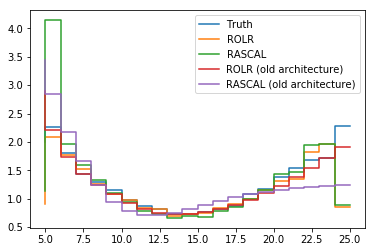

In [68]:
r_true = np.exp(np.log(p_estimated_0[5:-5]) - np.log(p_estimated_1[5:-5]))

x_test = to_categorical(np.array(range(n_nails)), num_classes=n_nails)
x_test_alt = np.array(range(n_nails))
theta0_test = np.array(theta_0 * np.ones(n_nails))

r_rolr = rolr.predict([theta0_test, x_test])[5:-5]
r_rascal = rascal.predict([theta0_test, x_test])[0][5:-5]
r_rolr_alt = rolr_alt.predict([theta0_test, x_test_alt])[5:-5]
r_rascal_alt = rascal_alt.predict([theta0_test, x_test_alt])[0][5:-5]

plt.step(range(5, n_nails - 5), r_true, label="Truth")
plt.step(range(5, n_nails - 5), r_rolr, label="ROLR")
plt.step(range(5, n_nails - 5), r_rascal, label="RASCAL")
plt.step(range(5, n_nails - 5), r_rolr_alt, label="ROLR (old architecture)")
plt.step(range(5, n_nails - 5), r_rascal_alt, label="RASCAL (old architecture)")
plt.legend()
plt.show()

---

# Model comparison

In [84]:
# Generate a big data sample
x_nde, t_xz_nde, theta_nde = draw_nde(100000)
np.save('data/nde_x.npy', x_nde)
np.save('data/nde_t.npy', t_xz_nde)
np.save('data/nde_theta.npy', theta_nde)

x, theta, y, r_xz, t_xz = draw_ratio(100000, categorical_x=False)
np.save('data/ratio_x.npy', x)
np.save('data/ratio_theta.npy', theta)
np.save('data/ratio_y.npy', y)
np.save('data/ratio_r_xz.npy', r_xz)
np.save('data/ratio_t_xz.npy', t_xz)

In [36]:
def compute_mse(p_train, p_estimated):
    p_ratio_train = np.log(p_train[0]) - np.log(p_train[1])
    p_ratio = np.log(p_estimated[0]) - np.log(p_estimated[1])
    mse = p_ratio_train - p_ratio
    mse[np.logical_or(np.isinf(mse), np.isnan(mse))] = 0.
    mse = np.dot(mse ** 2, p_estimated[1])
    return mse


def compute_mse_ratio(ratio, p_estimated, log=True):
    p_ratio = np.log(p_estimated[0]) - np.log(p_estimated[1])
    if log:
        p_ratio_train = np.log(ratio)
    else:
        p_ratio_train = ratio
    mse = p_ratio_train - p_ratio
    mse[np.logical_or(np.isinf(mse), np.isnan(mse))] = 0.
    mse = np.dot(mse ** 2, p_estimated[1])
    return mse

In [ ]:
mses_nde = []
mses_scandal = []
mses_carl = []
mses_carl_alt = []
mses_carl_calibrated = []
mses_rolr = []
mses_rolr_alt = []
mses_rascal = []
mses_rascal_alt = []

p_estimated = np.array([p_estimated_0, p_estimated_1])
samples_size = [100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000]
theta0_test = theta_0 * np.ones(n_nails)
x_test = to_categorical(np.array(range(n_nails)), num_classes=n_nails)
x_test_alt = np.array(range(n_nails))

for n in samples_size:
    print("{0} samples".format(n))
    
    # Load data
    indices = np.random.choice(100000, size=n, replace=False)
    
    x_nde = np.load('data/nde_x.npy')[indices]
    t_xz_nde = np.load('data/nde_t.npy')[indices]
    theta_nde = np.load('data/nde_theta.npy')[indices]
    
    x = np.load('data/ratio_x.npy')[indices]
    theta = np.load('data/ratio_theta.npy')[indices]
    y = np.load('data/ratio_y.npy')[indices]
    r_xz = np.load('data/ratio_r_xz.npy')[indices]
    t_xz = np.load('data/ratio_t_xz.npy')[indices]

    x_categorical = to_categorical(x, num_classes=n_nails)
    r_xz_y = np.hstack([r_xz, y.reshape((-1,1))])
    t_xz_y = np.hstack([t_xz, y.reshape((-1,1))])
    
    # NDE - SCANDAL
    nde = make_nde()
    nde.fit(
        theta_nde,
        x_nde,
        batch_size=32,
        epochs=50,
        verbose=0
    )
    scandal = make_scandal()
    scandal.fit(
        [theta_nde, x_nde],
        [x_nde, t_xz_nde],
        batch_size=32,
        epochs=50,
        verbose=0
    )
    nde_pred = nde.predict([theta_0, theta_1])
    scandal_pred = scandal.predict(
        [np.array([[theta_0], [theta_1]]), np.zeros((2, n_nails))]
    )[0]
    mse_nde = compute_mse(nde_pred, p_estimated)
    mse_scandal = compute_mse(scandal_pred, p_estimated)
    
    # CARL
    carl = make_carl()
    carl.fit(
        [theta, x_categorical],
        y,
        batch_size=32,
        epochs=50,
        verbose=0
    )
    carl_pred = np.exp(log_r_from_s(
        carl.predict([theta0_test, x_test])[5:-5]
    ))
    mse_carl = compute_mse_ratio(
        carl_pred.flatten(),
        p_estimated[:, 5:-5],
        log=True
    )
    
    # CARL old architecture
    carl_alt = make_carl_alt()
    carl_alt.fit(
        [theta, x],
        y,
        batch_size=32,
        epochs=50,
        verbose=0
    )
    carl_alt_pred = np.exp(log_r_from_s(
        carl_alt.predict([theta0_test, x_test_alt])[5:-5]
    ))
    mse_carl_alt = compute_mse_ratio(
        carl_alt_pred.flatten(),
        p_estimated[:, 5:-5],
        log=True
    )
    
    # CARL old architecture calibrated
    carl_calibrated = make_calibrated_carl_alt(
        theta,
        x,
        y
    )
    carl_calibrated_pred = np.exp(log_r_from_s(
        carl_calibrated(theta0_test, x_test_alt)[5:-5]
    ))
    mse_carl_calibrated = compute_mse_ratio(
        carl_calibrated_pred.flatten(),
        p_estimated[:, 5:-5],
        log=True
    )
    
    # ROLR
    rolr = make_rolr()
    rolr.fit(
        [theta, x_categorical],
        r_xz_y,
        batch_size=32,
        epochs=50,
        verbose=0
    )
    rolr_pred = rolr.predict(
        [theta0_test, x_test]
    )[5:-5]
    mse_rolr = compute_mse_ratio(
        rolr_pred.flatten(),
        p_estimated[:, 5:-5],
        log=True
    )
    
    # ROLR old architecture
    rolr_alt = make_rolr_alt()
    rolr_alt.fit(
        [theta, x],
        r_xz_y,
        batch_size=32,
        epochs=50,
        verbose=0
    )
    rolr_alt_pred = rolr_alt.predict(
        [theta0_test, x_test_alt]
    )[5:-5]
    mse_rolr_alt = compute_mse_ratio(
        rolr_alt_pred.flatten(),
        p_estimated[:, 5:-5],
        log=True
    )
    
    
    # RASCAL
    rascal = make_rascal()
    rascal.fit(
        [theta, x_categorical],
        [r_xz_y, t_xz_y],
        batch_size=32,
        epochs=50,
        verbose=0,
    )
    rascal_pred = rascal.predict(
        [theta0_test, x_test]
    )[0][5:-5]
    mse_rascal = compute_mse_ratio(
        rascal_pred.flatten(),
        p_estimated[:, 5:-5],
        log=True
    )
    
    # RASCAL old architecture
    rascal_alt = make_rascal_alt()
    rascal_alt.fit(
        [theta, x],
        [r_xz_y, t_xz_y],
        batch_size=32,
        epochs=50,
        verbose=0
    )
    rascal_alt_pred = rascal_alt.predict(
        [theta0_test, x_test_alt]
    )[0][5:-5]
    mse_rascal_alt = compute_mse_ratio(
        rascal_alt_pred.flatten(),
        p_estimated[:, 5:-5],
        log=True
    )
    
    # Save
    mses_nde.append(mse_nde)
    mses_rascal.append(mse_rascal)
    mses_rascal_alt.append(mse_rascal_alt)
    mses_carl.append(mse_carl)
    mses_carl_alt.append(mse_carl_alt)
    mses_carl_calibrated.append(mse_carl_calibrated)
    mses_rolr.append(mse_rolr)
    mses_rolr_alt.append(mse_rolr_alt)
    mses_scandal.append(mse_scandal)
    
mses_nde = np.array(mses_nde)
mses_scandal = np.array(mses_scandal)
mses_rolr = np.array(mses_rolr)
mses_rolr_alt = np.array(mses_rolr_alt)
mses_rascal = np.array(mses_rascal)
mses_rascal_alt = np.array(mses_rascal_alt)
mses_carl = np.array(mses_carl)
mses_carl_alt = np.array(mses_carl_alt)
mses_carl_calibrated = np.array(mses_carl_calibrated)

100 samples


/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in subtract
  app.launch_new_instance()


200 samples
500 samples


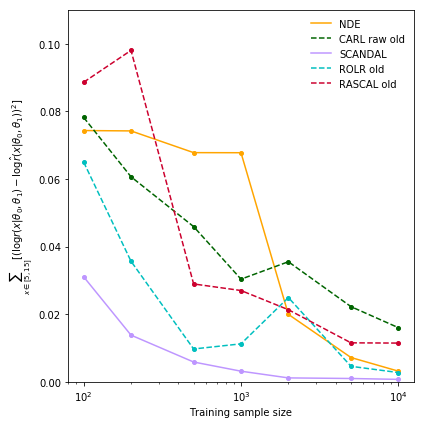

In [76]:
from utils import calculate_height, adjust_margins

mses = [mses_nde, mses_carl, mses_carl_alt, mses_carl_calibrated,
        mses_scandal, mses_rolr, mses_rolr_alt, mses_rascal, mses_rascal_alt]
labels = ['NDE', 'CARL raw', 'CARL raw old', 'CARL calibrated old',
          'SCANDAL', 'ROLR', 'ROLR old', 'RASCAL', 'RASCAL old']

colors     = ['orange', 'darkgreen', 'darkgreen', 'darkgreen',
              '#be96ff', 'c', 'c', '#CC002E', '#CC002E']
linestyles = ['-', '-', '--', '-.', '-', '-', '--', '-', '--']
linewidths = [1.5] * 10
markers    = ['o'] * 10

fig = plt.figure(figsize=(4.5,calculate_height(1,4.5,extra_top_space=False)))
#fig = plt.figure(figsize=(6.,6.))
ax = plt.gca()

for s in range(9):
    #if s in [1,3,5,7]:
    #    continue
    plt.plot(samples_size, mses[s], 
             ms=4., marker=markers[s],
             color=colors[s],
             lw=linewidths[s], ls=linestyles[s])
    plt.plot([], [],
             color=colors[s],
             lw=linewidths[s], ls=linestyles[s],
             label=labels[s])

ax.set_xscale("log", nonposx='clip')
#ax.set_yscale("log", nonposy='clip')
plt.ylim(0.,.1)
plt.xlabel(r"Training sample size")
plt.ylabel(r'$\sum_{x \in [5, 15]} [(\log r(x|\theta_0, \theta_1) - \log \hat{r}(x|\theta_0, \theta_1))^2]$')
plt.legend(frameon=False)

#plt.tight_layout()
adjust_margins(1,4.5,extra_top_space=False)
plt.savefig('plinko_models_comparison.pdf')